Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Community Detection/Clustering Algorithms

Clustering algorithms evaluate how nodes are clustered in communities, in closely-knit sets, or in highly or loosely interconnected groups.

These algorithms can identify meaningful groups or clusters of nodes in a network, revealing hidden patterns and structures that can provide insights into the organization and dynamics of complex systems. This is valuable in social network analysis and in biology, for identifying functional modules in protein-protein interaction networks, and more generally for understanding information flow and influence propagation in many different domains.

Different types of community algorithms use different techniques to determine the community of a node. Understanding how an algorithm calculates communities is important to understanding the meaning of its outputs.

In addition to returning community data to the client, Neptune Analytics provides mutate variations of the community detection algorithms which store the calculated centrality values as node properties in the graph.

## Supported Algorithms

Neptune Analytics supports the following community detection/clustering algorithms, each of which has a few variants:

* [Weakly Connected Components (WCC)](#WCC) -   The Weakly Connected Components (WCC) algorithm finds weakly-connected components in a directed graph. A weakly-connected component is a group of nodes where every node in the group is reachable from every other mode in the group if edge direction is ignored.
* [Strongly Connected Components (SCC)](#SCC) -  The Strongly Connected Components (SCC) algorithm identifies maximally connected subgraphs of a directed graph, where every node is reachable from every other node. This can provide insights into the tightly interconnected portions of a graph and highlight key structures within it.
* [Label Propagation](#Label-Propogation) -   Label Propagation Algorithm (LPA) is an algorithm tha assigns labels to nodes based on the consensus of their neighboring nodes, making it useful for identifying groups.

In addition to returning centrality data to the client, Neptune Analytics provides `mutate` variations of the centrality algorithms which store the calculated centrality values as a specified node property on each node in the graph.
    
## Loading Data
The first step in most projects is to load data to use for analysis.  For demonstration purposes, we have provided a set of datasets that can be used to demonstrate the features and functionality of Neptune Analytics. 

The cell below makes it easy to load the `air-routes` data into your graph.  The `air-routes` dataset we will be loading in this notebook is supplied as part of the [Practical Gremlin](https://kelvinlawrence.net/book/Gremlin-Graph-Guide.html#air) book.

The `air-route`'s graph contains several vertex types that are specified using labels. The most common ones being `airport` and `country`. There are also nodes for each of the seven continents (`continent`) and a single `version` vertex that I provided as a way to test which version of the graph you are using.

Routes between airports are modeled as edges. These edges carry the `route` label and include the distance between the two connected airport vertices as a property called `dist`. Connections between countries and airports are modelled using an edge with a `contains` label.

Each `airport` vertex has many properties associated with it giving various details about that airport including its IATA and ICAO codes, its description, the city it is in and its geographic location. A full data model of the `air-route`s graph is below.

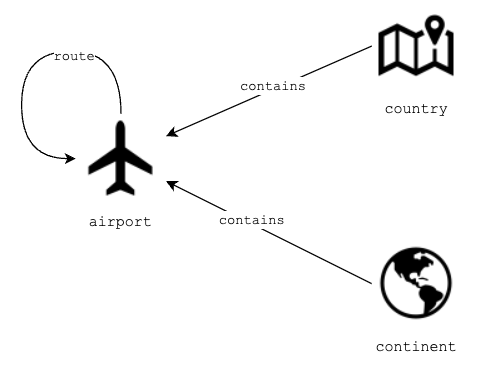

To load this dataset, run the two cells below.  This first cell will setup a few python variables using the configuration parameters of this Neptune Notebook.  The second cell will use Neptune Analytics batch load feature to load the data from the provided S3 bucket.  

**Note:** You only need to do this once. If you have already loaded the data previously you do not need to load it again.

In [ ]:
import graph_notebook as gn
config = gn.configuration.get_config.get_config()

s3_bucket = f"s3://aws-neptune-customer-samples-{config.aws_region}/sample-datasets/gremlin/air-routes/"
region = config.aws_region

In [ ]:
%%oc 

CALL neptune.load({format: "csv", 
                   source: "${s3_bucket}", 
                   region : "${region}"})

## WCC

The Weakly Connected Components (WCC) algorithm finds the weakly-connected components in a directed graph. A weakly-connected component is a group of nodes in which every node is reachable from every other node when edge directions are ignored. Weakly connected components are the maximal connected subgraphs of an undirected graph.

Identifying weakly-connected components helps in understanding the overall connectivity and structure of the graph. Weakly-connected components can be used in transportation networks to identify disconnected regions that may require improved connectivity, and in social networks to find isolated groups of users with limited interactions, and in webpage analysis to pinpoint sections with low accessibility.

Some common uses of the weakly connected components algorithm:

- Social network analysis - Analyzing groups/communities within a social network. Weak connections via shared contacts/friends help identify broader social circles.

- Software/library dependency analysis - Identifying all code/modules that directly or indirectly depend on each other. This helps understand potential impact of changes.

- Data integration/cleaning - Identifying records across different datasets that refer to the same real-world entities based on overlapping attribute values.

- Process/workflow analysis - Determining what steps/tasks within a larger process or workflow are inter-dependent, even if not sequentially linked.

- Bug/issue tracking - Grouping reported issues that may be related based on common libraries, components or configurations involved.

Problems where you need to identify interconnected or interdependent groups within a graph are good candidates for WCC.

### `wcc`
WCC defines communities or clusters in a graph as a group of nodes that are connected together, regardless of the direction of the edge.

Using our air routes data, let's find the number and size of WCC communities in our graph

In [ ]:
%%oc

MATCH (n)
CALL neptune.algo.wcc(n)
YIELD node, component
RETURN component, size(collect(node)) as component_size
ORDER BY component_size

Looking at the output of our algorithm we see that we have a total of 8 communities, one large community with several disconnected communities.  If we think about this in terms of our air routes network this makes sense, we would expect most to all the airports to be highly connected with one another.

### `wcc.mutate`
In addition to the `wcc` algorithm above there is a variant of the algorithm that stores the output value of the algorithm as to a property of each node, which is specified by the `writeProperty` parameter.

Let's see how we can use the `mutate` version and openCypher queries to answer the same question.

In [ ]:
%%oc
CALL neptune.algo.wcc.mutate({writeProperty: 'wcc'})

In [ ]:
%%oc

MATCH (n)
RETURN n.wcc, size(collect(n)) as component_size
ORDER BY component_size

As we see, both options return the same result. Using the `mutate` versions of algorithms is a very efficient way to store the algorithm output values to each node for later analysis by openCypher queries.  This is especially helpful when performing analysis on larger graphs where these calculations can be performed one time and reused across multiple queries.

## SCC
Strongly connected components (SCC) are the maximally connected subgraphs of a directed graph where every node is reachable from every other node (in other words, there exists a path between every node in the subgraph).

Some common uses of the strongly connected components (SCC) algorithm:

- Software dependency analysis - The SCC algorithm can analyze the dependencies between software modules/packages to identify tightly coupled groups. This helps understand the architecture and refactor/optimize dependencies. 

- Version control systems - Analyzing the commit graph in version control histories with SCCs can find changesets that are strongly inter-dependent, aiding tasks like release planning.

- Malware analysis - SCCs in the call graphs of malware behavior can help understand the control flow and modular structure of viruses/worms.

- Social network analysis - Finding cohesive groups via SCCs in networks like Facebook can have applications in community detection, influence and recommendations.

SCC is a good choice for problems that require identifying tightly coupled/interdependent subgroups or components is important.

### `scc`

SCC defines communities or clusters in a graph as a group of nodes that are connected together.  SCC, unlike WCC, takes into account the direction the edge.

Using our air routes data, let's find the number and size of SCC communities in our graph

In [ ]:
%%oc
MATCH (n)
CALL neptune.algo.scc(n)
YIELD node, component
RETURN component, size(collect(node)) as component_size
ORDER BY component_size

Comparing these SCC results against those that we received from WCC, we can see that including the direction of the edge in the calculation can drastically change the number of communities discovered.

### `scc.mutate`
As with `wcc.mutate` a variant of SCC exists, `scc.mutate` which will store the values of algorithm into a property on the node.

In [ ]:
%%oc
CALL neptune.algo.scc.mutate({writeProperty: 'scc'})

## Label Propogation
The label propagation algorithm is a graph-based semi-supervised learning method used for node classification. It starts by assigning each unlabeled node a uniform label distribution over all possible labels. Then it iteratively updates each node's label distribution based on the distributions of its neighbors - the label distribution is averaged over all neighbors. The algorithm converges when the label distributions no longer change or a maximum number of iterations is reached. The final label distribution of each unlabeled node is examined and the most probable label is assigned as the predicted label. By propagating label information from labeled to unlabeled nodes through the graph, the algorithm is able to classify unlabeled nodes based on their connectivity to labeled nodes in the graph.

 Common uses of label propagation algorithms:

- Semi-supervised learning - LPA is often used for semi-supervised learning tasks where only a small amount of labeled data is available. It can leverage both labeled and unlabeled data to classify new examples.

- Social network analysis - Analyzing social networks to identify groups, topics of interest, influential users etc. Labels represent categories or topics that spread through connections.

- Web page ranking - Similar to PageRank, but LPA propagates "importance" labels across hyperlinks to determine significance of web pages.

- Knowledge graph construction - Entities and relations in a knowledge graph can be labeled based on their connections to other labeled entities. 

- Recommender systems - Items can be recommended based on labels that propagate from a user's interests to related items through item-item connections.

Tasks involving grouping or classifying related nodes are good candidates for Label Propagation. The unlabeled propagation nature makes it useful for semi-supervised problems.



### `labelPropogation`

Label Propagation Algorithm (LPA) is an algorithm for community detection that is also used in semi-supervised machine learning for data classification. A community structure is loosely defined as a tightly knit group of entities in social networks.

Using our air routes data, let's find the number and size of labeled communities in our graph

In [ ]:
%%oc
MATCH (n)
CALL neptune.algo.labelPropagation(n)
YIELD node, community
RETURN community, size(collect(node)) as community_size
ORDER BY community_size

Comparing these results against those that we received from WCC and SCC, we can see that label propogation found a much larger number of communities.  As each of these algorithms defines community in slightly different ways, this is to be expected, so understanding how each algorithm defines a community is key to chosing the correct algorithm for a use case.

### `labelPropogation.mutate`
As with `wcc.mutate` and `scc.mutate` a variant of Label Propogation exists, `labelPropogation.mutate` which will store the values of algorithm into a property on the node.

In [ ]:
%%oc
CALL neptune.algo.labelPropagation.mutate({writeProperty: 'lpa'})

## Next Steps
In this notebook, we have demonstrated how to use the community detection algorithms provided by Neptune Analytics.  If you are interested in the other types of algorithms offered please look at the other notebooks available:

* [Path finding algorithms](./02-Path-Finding-Algorithms.ipynb)

* [Centrality algorithms](./03-Centrality-Algorithms.ipynb)

* [Similarity algorithms](./05-Similarity-Algorithms.ipynb)